In [1]:
import pandas as pd
from datasets import load_dataset
from transformers import pipeline
from tqdm import tqdm
import os
import re
import matplotlib.pyplot as plt
import torch
import seaborn as sns

pd.set_option('future.no_silent_downcasting', True)

In [2]:
test = pd.read_csv('./data/polnli_test_results.csv')
alts = pd.read_csv('./data/hypothesis_variants.csv')

# merge with alternative hypotheses
test = pd.merge(test, alts, how = 'left', left_on = 'hypothesis', right_on = 'original')

# drop observations that don't have AI generated alternatives
test = test[~test['original'].isna()].reset_index(drop = True)

# drop columns I don't need
test.drop(['augmented_hypothesis', 'base_nli', 'large_nli', 'base_debate', 'large_debate', 'base_modern', 'large_modern', 'llama', 'sonnet', 'original', 'alt4'], axis = 1, inplace = True)

In [ ]:
def hypothesis_stability(df):
    """
    Calculate the probability that a document's label changes when using different hypotheses.
    For each document (row), compares all possible pairs of labels to determine how often they differ.

    Accepts the PolNLI_hypothesis_stability_test as a dataframe
    
    Returns:
        float: Probability between 0 and 1 representing how often the label changes when
              using different hypotheses.
    """
    # Each row has 4 prompts, so we have 6 possible pairs per row (4 choose 2)
    n_prompts = 4
    pairs_per_row = (n_prompts * (n_prompts - 1)) // 2  # combinations is n_prompts choose 2
    
    # Count differences for each row
    total_differences = 0
    
    for idx in df.index:
        # Get all labels for this document
        labels = df.iloc[idx]
        
        # Compare each pair of labels
        # We'll have 6 comparisons: (1,2), (1,3), (1,4), (2,3), (2,4), (3,4)
        differences = 0
        for i in range(n_prompts):
            for j in range(i + 1, n_prompts):
                if labels.iloc[i] != labels.iloc[j]:
                    differences += 1
        
        total_differences += differences
    
    # Calculate probability
    # Total comparisons = 6 pairs per row * number of rows
    total_comparisons = pairs_per_row * len(df)
    probability = total_differences / total_comparisons
    
    return probability

def stability_benchmark(model_folder, batch_size=16):
    """
    Runs a stability benchmark for models in a specified folder.

    Parameters:
    - model_folder: str, path to the folder containing model checkpoints.
    - batch_size: int, batch size for the pipeline.

    Returns:
    - stability_df: pd.DataFrame, DataFrame containing stability results.
    """
    # Get a sorted list of checkpoint folders
    checkpoints = sorted(
        [
            os.path.join(model_folder, d) for d in os.listdir(model_folder)
            if os.path.isdir(os.path.join(model_folder, d)) and re.match(r'checkpoint-\d+', d)
        ],
        key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1))
    )

    # Prepare to store stability results
    stability_results = []

    # Iterate over each checkpoint
    for model_path in tqdm(checkpoints, desc="Processing models"):
        # Load the pipeline for the current checkpoint
        pipe = pipeline('text-classification', model=model_path, batch_size=batch_size, torch_dtype=torch.bfloat16)

        colnames = ['hypothesis', 'alt1', 'alt2', 'alt3']
        for col in tqdm(colnames, desc=f'Classifying columns in {model_path}'):
            colname = col + '_label'
            dicts = [{'text': test.loc[i, 'premise'], 'text_pair': test.loc[i, col]} for i in test.index]
            res = pipe(dicts)
            res = [result['label'] for result in res]
            test[colname] = res
            test[colname] = test[colname].replace({'entailment': 0, 'not_entailment': 1}).astype(int)

        stability = hypothesis_stability(test[['hypothesis_label', 'alt1_label', 'alt2_label', 'alt3_label']])
        checkpoint_number = int(re.search(r'checkpoint-(\d+)', model_path).group(1))
        stability_results.append((checkpoint_number, stability))
        # Print the result for the current model
        print(f"Checkpoint {checkpoint_number}: Stability = {stability}")

    # Convert results to a DataFrame
    stability_df = pd.DataFrame(stability_results, columns=["Checkpoint", "Stability"])
    # Sort by checkpoint for plotting
    stability_df.sort_values("Checkpoint", inplace=True)

    return stability_df

def plot_stability(data, title, save_path=None):
    """
    Plots stability data with a customizable title and a legend for colors.

    Parameters:
    - data: DataFrame or list of DataFrames containing "Checkpoint", "Stability", and optionally "Model" columns.
    - title: str, the title of the plot.
    - save_path: str, optional. File path to save the plot. If None, the plot is not saved.
    """
    sns.set_theme(style="whitegrid", palette="colorblind")

    # Check if data is a list of DataFrames and concatenate if needed
    if isinstance(data, list):
        data = pd.concat(data, ignore_index=True)

    # Create the plot
    plt.figure(figsize=(10, 6))
    ax = sns.lineplot(data=data, x="Checkpoint", y="Stability", hue="Model", marker="o")

    # Customize the plot
    plt.title(title, fontsize=18, fontweight='bold')
    plt.xlabel("Training Step", fontsize=16, fontweight='bold')
    plt.ylabel("P(Label Change|Hypothesis Change)", fontsize=16, fontweight='bold')

    # Remove top and right spines
    sns.despine(top=True, right=True)

    # Remove grid lines
    plt.grid(False)

    # Set y-axis limit
    plt.ylim(0, 0.07)

    # Customize legend: remove title
    legend = ax.get_legend()
    if legend:
        legend.set_title(None)

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    # Show the plot
    plt.show()

# ModernBERT Base

In [6]:
mbb = stability_benchmark("training_ModernBase", batch_size = 64)
mbb['Model'] = 'Modern BERT Base'

You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-10706:  25%|████            | 1/4 [00:04<00:12,  4.29s/it]
ssifying columns in training_ModernBase/checkpoint-10706:  50%|████████        | 2/4 [00:08<00:08,  4.03s/it]
ssifying columns in training_ModernBase/checkpoint-10706:  75%|████████████    | 3/4 [00:12<00:03,  3.96s/it]
Classifying columns in training_ModernBase/checkpoint-10706: 100%|████████████████| 4/4 [00:15<00:00,  3.98s/it]
Device set to use cuda:0█████▋                                                   | 1/10 [00:16<02:32, 16.92s/it]


Checkpoint 10706: Stability = 0.052264291017074985



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-21412:  25%|████            | 1/4 [00:03<00:11,  3.91s/it]
ssifying columns in training_ModernBase/checkpoint-21412:  50%|████████        | 2/4 [00:07<00:07,  3.93s/it]
ssifying columns in training_ModernBase/checkpoint-21412:  75%|████████████    | 3/4 [00:12<00:04,  4.03s/it]
Classifying columns in training_ModernBase/checkpoint-21412: 100%|████████████████| 4/4 [00:16<00:00,  4.05s/it]
Device set to use cuda:0███████████▍                                             | 2/10 [00:33<02:13, 16.69s/it]


Checkpoint 21412: Stability = 0.05022271714922049



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-32118:  25%|████            | 1/4 [00:04<00:12,  4.12s/it]
ssifying columns in training_ModernBase/checkpoint-32118:  50%|████████        | 2/4 [00:08<00:08,  4.05s/it]
ssifying columns in training_ModernBase/checkpoint-32118:  75%|████████████    | 3/4 [00:12<00:04,  4.04s/it]
Classifying columns in training_ModernBase/checkpoint-32118: 100%|████████████████| 4/4 [00:16<00:00,  4.06s/it]
Device set to use cuda:0█████████████████                                        | 3/10 [00:50<01:56, 16.64s/it]


Checkpoint 32118: Stability = 0.049368968077208614



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-42824:  25%|████            | 1/4 [00:03<00:11,  4.00s/it]
ssifying columns in training_ModernBase/checkpoint-42824:  50%|████████        | 2/4 [00:07<00:07,  3.99s/it]
ssifying columns in training_ModernBase/checkpoint-42824:  75%|████████████    | 3/4 [00:12<00:04,  4.09s/it]
Classifying columns in training_ModernBase/checkpoint-42824: 100%|████████████████| 4/4 [00:16<00:00,  4.09s/it]
Device set to use cuda:0██████████████████████▊                                  | 4/10 [01:06<01:39, 16.66s/it]


Checkpoint 42824: Stability = 0.045712694877505566



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-53530:  25%|████            | 1/4 [00:03<00:11,  3.97s/it]
ssifying columns in training_ModernBase/checkpoint-53530:  50%|████████        | 2/4 [00:07<00:07,  3.96s/it]
ssifying columns in training_ModernBase/checkpoint-53530:  75%|████████████    | 3/4 [00:11<00:03,  3.96s/it]
Classifying columns in training_ModernBase/checkpoint-53530: 100%|████████████████| 4/4 [00:15<00:00,  3.99s/it]
Device set to use cuda:0████████████████████████████▌                            | 5/10 [01:22<01:22, 16.52s/it]


Checkpoint 53530: Stability = 0.04478470675575353



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-64236:  25%|████            | 1/4 [00:03<00:11,  3.96s/it]
ssifying columns in training_ModernBase/checkpoint-64236:  50%|████████        | 2/4 [00:07<00:07,  3.99s/it]
ssifying columns in training_ModernBase/checkpoint-64236:  75%|████████████    | 3/4 [00:11<00:04,  4.00s/it]
Classifying columns in training_ModernBase/checkpoint-64236: 100%|████████████████| 4/4 [00:16<00:00,  4.01s/it]
Device set to use cuda:0██████████████████████████████████▏                      | 6/10 [01:39<01:05, 16.47s/it]


Checkpoint 64236: Stability = 0.04652932442464736



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-74942:  25%|████            | 1/4 [00:04<00:12,  4.01s/it]
ssifying columns in training_ModernBase/checkpoint-74942:  50%|████████        | 2/4 [00:07<00:07,  3.96s/it]
ssifying columns in training_ModernBase/checkpoint-74942:  75%|████████████    | 3/4 [00:12<00:04,  4.01s/it]
Classifying columns in training_ModernBase/checkpoint-74942: 100%|████████████████| 4/4 [00:16<00:00,  4.02s/it]
Device set to use cuda:0███████████████████████████████████████▉                 | 7/10 [01:55<00:49, 16.44s/it]


Checkpoint 74942: Stability = 0.05261692650334076



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-85648:  25%|████            | 1/4 [00:04<00:12,  4.05s/it]
ssifying columns in training_ModernBase/checkpoint-85648:  50%|████████        | 2/4 [00:08<00:08,  4.15s/it]
ssifying columns in training_ModernBase/checkpoint-85648:  75%|████████████    | 3/4 [00:12<00:04,  4.18s/it]
Classifying columns in training_ModernBase/checkpoint-85648: 100%|████████████████| 4/4 [00:16<00:00,  4.17s/it]
Device set to use cuda:0█████████████████████████████████████████████▌           | 8/10 [02:12<00:33, 16.62s/it]


Checkpoint 85648: Stability = 0.04543429844097996



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-96354:  25%|████            | 1/4 [00:04<00:12,  4.02s/it]
ssifying columns in training_ModernBase/checkpoint-96354:  50%|████████        | 2/4 [00:08<00:08,  4.01s/it]
ssifying columns in training_ModernBase/checkpoint-96354:  75%|████████████    | 3/4 [00:12<00:04,  4.01s/it]
Classifying columns in training_ModernBase/checkpoint-96354: 100%|████████████████| 4/4 [00:16<00:00,  4.04s/it]
Device set to use cuda:0███████████████████████████████████████████████████▎     | 9/10 [02:29<00:16, 16.58s/it]


Checkpoint 96354: Stability = 0.04398663697104677



Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernBase/checkpoint-107060:  25%|███▊           | 1/4 [00:03<00:11,  3.99s/it]
ssifying columns in training_ModernBase/checkpoint-107060:  50%|███████▌       | 2/4 [00:08<00:08,  4.01s/it]
ssifying columns in training_ModernBase/checkpoint-107060:  75%|███████████▎   | 3/4 [00:12<00:04,  4.02s/it]
Classifying columns in training_ModernBase/checkpoint-107060: 100%|███████████████| 4/4 [00:16<00:00,  4.04s/it]
Processing models: 100%|████████████████████████████████████████████████████████| 10/10 [02:45<00:00, 16.57s/it]

Checkpoint 107060: Stability = 0.04578693392724573


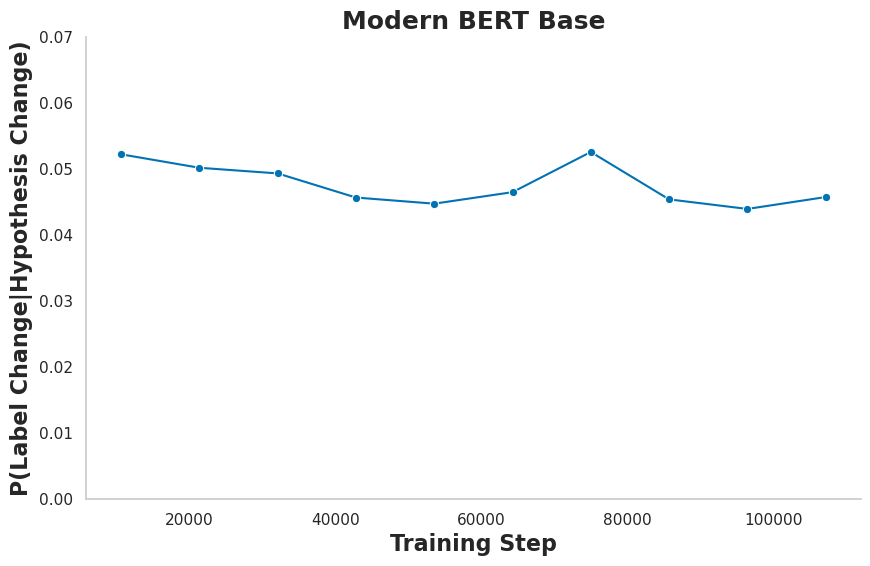

In [7]:
plot_stability(mbb, "Modern BERT Base")

# ModernBERT Large

Device set to use cuda:0                                                                 | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-10705:  25%|███▊           | 1/4 [00:08<00:25,  8.40s/it]
ssifying columns in training_ModernLarge/checkpoint-10705:  50%|███████▌       | 2/4 [00:16<00:16,  8.02s/it]
ssifying columns in training_ModernLarge/checkpoint-10705:  75%|███████████▎   | 3/4 [00:24<00:07,  8.00s/it]
Classifying columns in training_ModernLarge/checkpoint-10705: 100%|███████████████| 4/4 [00:32<00:00,  8.03s/it]
Processing models:  10%|█████▋                                                   | 1/10 [00:33<04:59, 33.32s/it]

Checkpoint 10705: Stability = 0.032015590200445435


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-21410:  25%|███▊           | 1/4 [00:07<00:23,  7.75s/it]
ssifying columns in training_ModernLarge/checkpoint-21410:  50%|███████▌       | 2/4 [00:15<00:15,  7.80s/it]
ssifying columns in training_ModernLarge/checkpoint-21410:  75%|███████████▎   | 3/4 [00:23<00:07,  7.86s/it]
Classifying columns in training_ModernLarge/checkpoint-21410: 100%|███████████████| 4/4 [00:31<00:00,  7.91s/it]
Processing models:  20%|███████████▍                                             | 2/10 [01:05<04:23, 32.91s/it]

Checkpoint 21410: Stability = 0.030864884929472904


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-32115:  25%|███▊           | 1/4 [00:07<00:23,  7.83s/it]
ssifying columns in training_ModernLarge/checkpoint-32115:  50%|███████▌       | 2/4 [00:15<00:15,  7.86s/it]
ssifying columns in training_ModernLarge/checkpoint-32115:  75%|███████████▎   | 3/4 [00:23<00:07,  7.88s/it]
Classifying columns in training_ModernLarge/checkpoint-32115: 100%|███████████████| 4/4 [00:31<00:00,  7.93s/it]
Processing models:  30%|█████████████████                                        | 3/10 [01:38<03:49, 32.83s/it]

Checkpoint 32115: Stability = 0.03583890126206384


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-42820:  25%|███▊           | 1/4 [00:07<00:23,  7.96s/it]
ssifying columns in training_ModernLarge/checkpoint-42820:  50%|███████▌       | 2/4 [00:15<00:16,  8.00s/it]
ssifying columns in training_ModernLarge/checkpoint-42820:  75%|███████████▎   | 3/4 [00:24<00:08,  8.02s/it]
Classifying columns in training_ModernLarge/checkpoint-42820: 100%|███████████████| 4/4 [00:32<00:00,  8.05s/it]
Processing models:  40%|██████████████████████▊                                  | 4/10 [02:11<03:17, 32.99s/it]

Checkpoint 42820: Stability = 0.03767631774313289


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-53525:  25%|███▊           | 1/4 [00:07<00:23,  7.83s/it]
ssifying columns in training_ModernLarge/checkpoint-53525:  50%|███████▌       | 2/4 [00:15<00:15,  7.91s/it]
ssifying columns in training_ModernLarge/checkpoint-53525:  75%|███████████▎   | 3/4 [00:23<00:07,  7.98s/it]
Classifying columns in training_ModernLarge/checkpoint-53525: 100%|███████████████| 4/4 [00:32<00:00,  8.03s/it]
Processing models:  50%|████████████████████████████▌                            | 5/10 [02:45<02:45, 33.05s/it]

Checkpoint 53525: Stability = 0.034261321455085376


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-64230:  25%|███▊           | 1/4 [00:07<00:23,  7.96s/it]
ssifying columns in training_ModernLarge/checkpoint-64230:  50%|███████▌       | 2/4 [00:16<00:16,  8.04s/it]
ssifying columns in training_ModernLarge/checkpoint-64230:  75%|███████████▎   | 3/4 [00:24<00:08,  8.03s/it]
Classifying columns in training_ModernLarge/checkpoint-64230: 100%|███████████████| 4/4 [00:32<00:00,  8.07s/it]
Processing models:  60%|██████████████████████████████████▏                      | 6/10 [03:18<02:12, 33.18s/it]

Checkpoint 64230: Stability = 0.03793615441722346


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-74935:  25%|███▊           | 1/4 [00:07<00:23,  8.00s/it]
ssifying columns in training_ModernLarge/checkpoint-74935:  50%|███████▌       | 2/4 [00:15<00:15,  7.96s/it]
ssifying columns in training_ModernLarge/checkpoint-74935:  75%|███████████▎   | 3/4 [00:23<00:07,  7.97s/it]
Classifying columns in training_ModernLarge/checkpoint-74935: 100%|███████████████| 4/4 [00:32<00:00,  8.04s/it]
Processing models:  70%|███████████████████████████████████████▉                 | 7/10 [03:51<01:39, 33.22s/it]

Checkpoint 74935: Stability = 0.029305864884929474


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-85640:  25%|███▊           | 1/4 [00:07<00:23,  7.76s/it]
ssifying columns in training_ModernLarge/checkpoint-85640:  50%|███████▌       | 2/4 [00:15<00:15,  7.79s/it]
ssifying columns in training_ModernLarge/checkpoint-85640:  75%|███████████▎   | 3/4 [00:23<00:07,  7.83s/it]
Classifying columns in training_ModernLarge/checkpoint-85640: 100%|███████████████| 4/4 [00:31<00:00,  7.86s/it]
Processing models:  80%|█████████████████████████████████████████████▌           | 8/10 [04:24<01:06, 33.02s/it]

Checkpoint 85640: Stability = 0.03283221974758723


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-96345:  25%|███▊           | 1/4 [00:07<00:23,  7.72s/it]
ssifying columns in training_ModernLarge/checkpoint-96345:  50%|███████▌       | 2/4 [00:15<00:15,  7.75s/it]
ssifying columns in training_ModernLarge/checkpoint-96345:  75%|███████████▎   | 3/4 [00:23<00:07,  7.80s/it]
Classifying columns in training_ModernLarge/checkpoint-96345: 100%|███████████████| 4/4 [00:31<00:00,  7.83s/it]
Processing models:  90%|███████████████████████████████████████████████████▎     | 9/10 [04:56<00:32, 32.85s/it]

Checkpoint 96345: Stability = 0.030939123979213067


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (733 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_ModernLarge/checkpoint-107050:  25%|███▌          | 1/4 [00:08<00:24,  8.19s/it]
ssifying columns in training_ModernLarge/checkpoint-107050:  50%|███████       | 2/4 [00:16<00:15,  7.97s/it]
ssifying columns in training_ModernLarge/checkpoint-107050:  75%|██████████▌   | 3/4 [00:23<00:07,  7.93s/it]
Classifying columns in training_ModernLarge/checkpoint-107050: 100%|██████████████| 4/4 [00:31<00:00,  7.97s/it]
Processing models: 100%|████████████████████████████████████████████████████████| 10/10 [05:29<00:00, 32.99s/it]


Checkpoint 107050: Stability = 0.030976243504083147


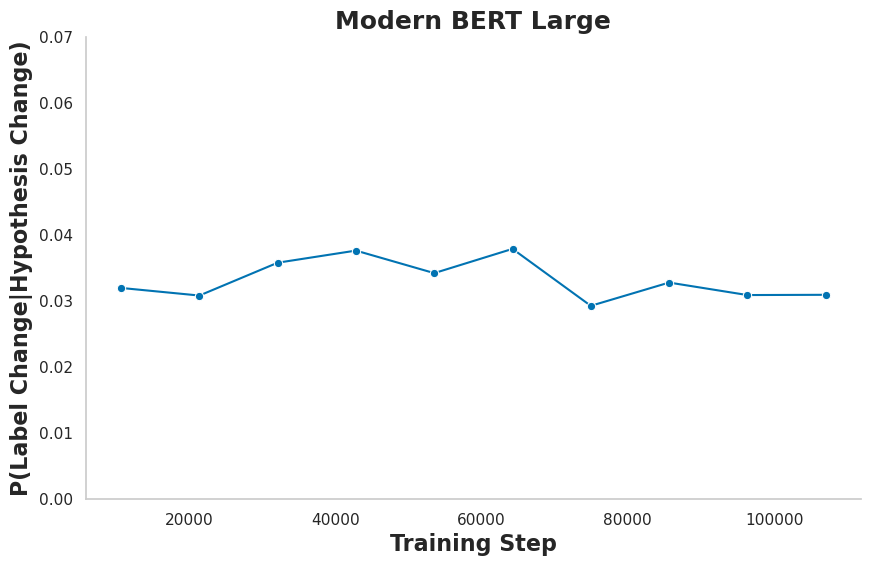

In [9]:
mbl = stability_benchmark("training_ModernLarge", batch_size = 128)
mbl['Model'] = 'Modern BERT Large'
plot_stability(mbl, "Modern BERT Large")

# DeBERTa Base

Device set to use cuda:0                                                                 | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-10706:  25%|█████▌                | 1/4 [00:12<00:36, 12.15s/it]
ssifying columns in training_base/checkpoint-10706:  50%|███████████           | 2/4 [00:23<00:23, 11.95s/it]
ssifying columns in training_base/checkpoint-10706:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.87s/it]
Classifying columns in training_base/checkpoint-10706: 100%|██████████████████████| 4/4 [00:47<00:00, 11.94s/it]
Processing models:  10%|█████▋                                                   | 1/10 [00:48<07:16, 48.45s/it]

Checkpoint 10706: Stability = 0.03973645137342242


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-21412:  25%|█████▌                | 1/4 [00:11<00:35, 11.78s/it]
ssifying columns in training_base/checkpoint-21412:  50%|███████████           | 2/4 [00:23<00:23, 12.00s/it]
ssifying columns in training_base/checkpoint-21412:  75%|████████████████▌     | 3/4 [00:36<00:12, 12.04s/it]
Classifying columns in training_base/checkpoint-21412: 100%|██████████████████████| 4/4 [00:47<00:00, 12.00s/it]
Processing models:  20%|███████████▍                                             | 2/10 [01:37<06:30, 48.77s/it]

Checkpoint 21412: Stability = 0.033129175946547886


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-32118:  25%|█████▌                | 1/4 [00:12<00:36, 12.08s/it]
ssifying columns in training_base/checkpoint-32118:  50%|███████████           | 2/4 [00:23<00:23, 11.84s/it]
ssifying columns in training_base/checkpoint-32118:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.77s/it]
Classifying columns in training_base/checkpoint-32118: 100%|██████████████████████| 4/4 [00:47<00:00, 11.82s/it]
Processing models:  30%|█████████████████                                        | 3/10 [02:25<05:39, 48.47s/it]

Checkpoint 32118: Stability = 0.038084632516703784


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-42824:  25%|█████▌                | 1/4 [00:11<00:35, 11.97s/it]
ssifying columns in training_base/checkpoint-42824:  50%|███████████           | 2/4 [00:23<00:23, 11.92s/it]
ssifying columns in training_base/checkpoint-42824:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.95s/it]
Classifying columns in training_base/checkpoint-42824: 100%|██████████████████████| 4/4 [00:47<00:00, 11.99s/it]
Processing models:  40%|██████████████████████▊                                  | 4/10 [03:14<04:51, 48.59s/it]

Checkpoint 42824: Stability = 0.02605790645879733


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-53530:  25%|█████▌                | 1/4 [00:12<00:36, 12.07s/it]
ssifying columns in training_base/checkpoint-53530:  50%|███████████           | 2/4 [00:24<00:24, 12.14s/it]
ssifying columns in training_base/checkpoint-53530:  75%|████████████████▌     | 3/4 [00:36<00:12, 12.03s/it]
Classifying columns in training_base/checkpoint-53530: 100%|██████████████████████| 4/4 [00:48<00:00, 12.04s/it]
Processing models:  50%|████████████████████████████▌                            | 5/10 [04:03<04:03, 48.71s/it]

Checkpoint 53530: Stability = 0.03752783964365256


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-64236:  25%|█████▌                | 1/4 [00:11<00:35, 12.00s/it]
ssifying columns in training_base/checkpoint-64236:  50%|███████████           | 2/4 [00:24<00:24, 12.04s/it]
ssifying columns in training_base/checkpoint-64236:  75%|████████████████▌     | 3/4 [00:36<00:12, 12.08s/it]
Classifying columns in training_base/checkpoint-64236: 100%|██████████████████████| 4/4 [00:48<00:00, 12.03s/it]
Processing models:  60%|██████████████████████████████████▏                      | 6/10 [04:52<03:15, 48.77s/it]

Checkpoint 64236: Stability = 0.04857089829250186


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-74942:  25%|█████▌                | 1/4 [00:11<00:35, 11.80s/it]
ssifying columns in training_base/checkpoint-74942:  50%|███████████           | 2/4 [00:23<00:23, 11.84s/it]
ssifying columns in training_base/checkpoint-74942:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.98s/it]
Classifying columns in training_base/checkpoint-74942: 100%|██████████████████████| 4/4 [00:47<00:00, 11.97s/it]
Processing models:  70%|███████████████████████████████████████▉                 | 7/10 [05:40<02:26, 48.74s/it]

Checkpoint 74942: Stability = 0.049201930215293246


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-85648:  25%|█████▌                | 1/4 [00:11<00:35, 11.80s/it]
ssifying columns in training_base/checkpoint-85648:  50%|███████████           | 2/4 [00:23<00:23, 11.90s/it]
ssifying columns in training_base/checkpoint-85648:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.90s/it]
Classifying columns in training_base/checkpoint-85648: 100%|██████████████████████| 4/4 [00:47<00:00, 11.84s/it]
Processing models:  80%|█████████████████████████████████████████████▌           | 8/10 [06:29<01:37, 48.58s/it]

Checkpoint 85648: Stability = 0.045842613214550854


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-96354:  25%|█████▌                | 1/4 [00:11<00:35, 11.71s/it]
ssifying columns in training_base/checkpoint-96354:  50%|███████████           | 2/4 [00:23<00:23, 11.64s/it]
ssifying columns in training_base/checkpoint-96354:  75%|████████████████▌     | 3/4 [00:35<00:11, 11.69s/it]
Classifying columns in training_base/checkpoint-96354: 100%|██████████████████████| 4/4 [00:46<00:00, 11.72s/it]
Processing models:  90%|███████████████████████████████████████████████████▎     | 9/10 [07:16<00:48, 48.28s/it]

Checkpoint 96354: Stability = 0.03700816629547142


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_base/checkpoint-107060:  25%|█████▎               | 1/4 [00:11<00:34, 11.54s/it]
ssifying columns in training_base/checkpoint-107060:  50%|██████████▌          | 2/4 [00:23<00:23, 11.53s/it]
ssifying columns in training_base/checkpoint-107060:  75%|███████████████▊     | 3/4 [00:34<00:11, 11.58s/it]
Classifying columns in training_base/checkpoint-107060: 100%|█████████████████████| 4/4 [00:46<00:00, 11.60s/it]
Processing models: 100%|████████████████████████████████████████████████████████| 10/10 [08:03<00:00, 48.38s/it]


Checkpoint 107060: Stability = 0.03530066815144766


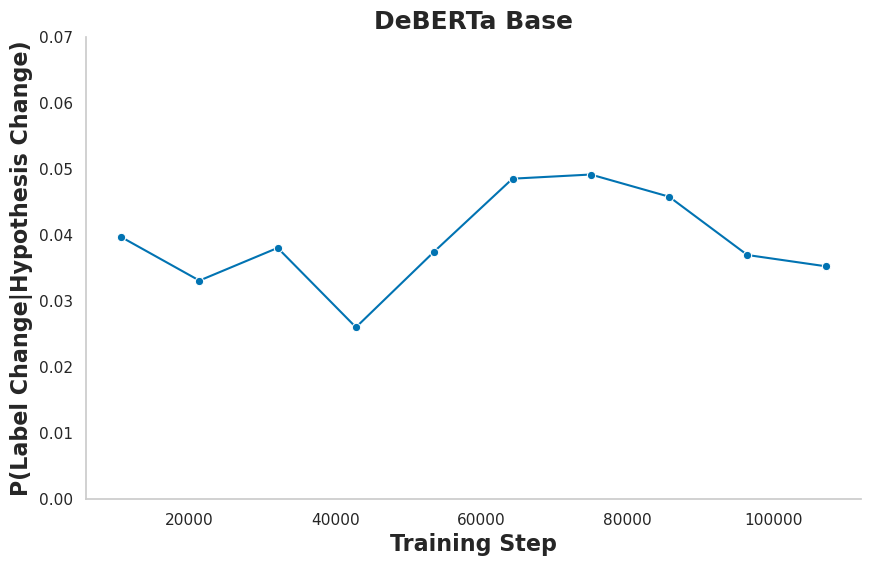

In [10]:
db = stability_benchmark("training_base", batch_size = 8)
db['Model'] = 'DeBERTa Base'
plot_stability(db, "DeBERTa Base")

# DeBERTa Large

Device set to use cuda:0                                                                 | 0/10 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-10705:  25%|█████               | 1/4 [00:26<01:20, 26.98s/it]
ssifying columns in training_large2/checkpoint-10705:  50%|██████████          | 2/4 [00:53<00:53, 26.67s/it]
ssifying columns in training_large2/checkpoint-10705:  75%|███████████████     | 3/4 [01:20<00:26, 26.76s/it]
Classifying columns in training_large2/checkpoint-10705: 100%|████████████████████| 4/4 [01:47<00:00, 26.84s/it]
Processing models:  10%|█████▌                                                  | 1/10 [01:48<16:20, 108.92s/it]

Checkpoint 10705: Stability = 0.029213066072754267


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-21410:  25%|█████               | 1/4 [00:26<01:20, 26.83s/it]
ssifying columns in training_large2/checkpoint-21410:  50%|██████████          | 2/4 [00:53<00:53, 26.76s/it]
ssifying columns in training_large2/checkpoint-21410:  75%|███████████████     | 3/4 [01:20<00:26, 26.87s/it]
Classifying columns in training_large2/checkpoint-21410: 100%|████████████████████| 4/4 [01:47<00:00, 26.93s/it]
Processing models:  20%|███████████▏                                            | 2/10 [03:37<14:31, 108.95s/it]

Checkpoint 21410: Stability = 0.042074981440237566


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-32115:  25%|█████               | 1/4 [00:26<01:19, 26.65s/it]
ssifying columns in training_large2/checkpoint-32115:  50%|██████████          | 2/4 [00:53<00:53, 26.73s/it]
ssifying columns in training_large2/checkpoint-32115:  75%|███████████████     | 3/4 [01:20<00:26, 26.86s/it]
Classifying columns in training_large2/checkpoint-32115: 100%|████████████████████| 4/4 [01:47<00:00, 26.86s/it]
Processing models:  30%|████████████████▊                                       | 3/10 [05:26<12:41, 108.82s/it]

Checkpoint 32115: Stability = 0.02592798812175204


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-42820:  25%|█████               | 1/4 [00:26<01:20, 26.85s/it]
ssifying columns in training_large2/checkpoint-42820:  50%|██████████          | 2/4 [00:53<00:53, 26.87s/it]
ssifying columns in training_large2/checkpoint-42820:  75%|███████████████     | 3/4 [01:20<00:26, 26.95s/it]
Classifying columns in training_large2/checkpoint-42820: 100%|████████████████████| 4/4 [01:47<00:00, 26.98s/it]
Processing models:  40%|██████████████████████▍                                 | 4/10 [07:15<10:53, 108.95s/it]

Checkpoint 42820: Stability = 0.027951002227171493


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-53525:  25%|█████               | 1/4 [00:26<01:20, 26.67s/it]
ssifying columns in training_large2/checkpoint-53525:  50%|██████████          | 2/4 [00:53<00:53, 26.75s/it]
ssifying columns in training_large2/checkpoint-53525:  75%|███████████████     | 3/4 [01:20<00:26, 26.89s/it]
Classifying columns in training_large2/checkpoint-53525: 100%|████████████████████| 4/4 [01:47<00:00, 26.89s/it]
Processing models:  50%|████████████████████████████                            | 5/10 [09:04<09:04, 108.90s/it]

Checkpoint 53525: Stability = 0.029788418708240536


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-64230:  25%|█████               | 1/4 [00:26<01:20, 26.81s/it]
ssifying columns in training_large2/checkpoint-64230:  50%|██████████          | 2/4 [00:53<00:53, 26.87s/it]
ssifying columns in training_large2/checkpoint-64230:  75%|███████████████     | 3/4 [01:20<00:27, 27.05s/it]
Classifying columns in training_large2/checkpoint-64230: 100%|████████████████████| 4/4 [01:48<00:00, 27.13s/it]
Processing models:  60%|█████████████████████████████████▌                      | 6/10 [10:54<07:16, 109.19s/it]

Checkpoint 64230: Stability = 0.030697847067557536


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-74935:  25%|█████               | 1/4 [00:26<01:20, 26.81s/it]
ssifying columns in training_large2/checkpoint-74935:  50%|██████████          | 2/4 [00:53<00:53, 26.78s/it]
ssifying columns in training_large2/checkpoint-74935:  75%|███████████████     | 3/4 [01:20<00:26, 26.93s/it]
Classifying columns in training_large2/checkpoint-74935: 100%|████████████████████| 4/4 [01:47<00:00, 26.94s/it]
Processing models:  70%|███████████████████████████████████████▏                | 7/10 [12:43<05:27, 109.13s/it]

Checkpoint 74935: Stability = 0.034391239792130664


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-85640:  25%|█████               | 1/4 [00:27<01:21, 27.02s/it]
ssifying columns in training_large2/checkpoint-85640:  50%|██████████          | 2/4 [00:54<00:54, 27.03s/it]
ssifying columns in training_large2/checkpoint-85640:  75%|███████████████     | 3/4 [01:21<00:27, 27.03s/it]
Classifying columns in training_large2/checkpoint-85640: 100%|████████████████████| 4/4 [01:48<00:00, 27.12s/it]
Processing models:  80%|████████████████████████████████████████████▊           | 8/10 [14:33<03:38, 109.33s/it]

Checkpoint 85640: Stability = 0.024387527839643652


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-96345:  25%|█████               | 1/4 [00:26<01:20, 26.99s/it]
ssifying columns in training_large2/checkpoint-96345:  50%|██████████          | 2/4 [00:53<00:53, 26.88s/it]
ssifying columns in training_large2/checkpoint-96345:  75%|███████████████     | 3/4 [01:20<00:26, 26.95s/it]
Classifying columns in training_large2/checkpoint-96345: 100%|████████████████████| 4/4 [01:47<00:00, 26.97s/it]
Processing models:  90%|██████████████████████████████████████████████████▍     | 9/10 [16:22<01:49, 109.27s/it]

Checkpoint 96345: Stability = 0.03105048255382331


Device set to use cuda:0

Token indices sequence length is longer than the specified maximum sequence length for this model (670 > 512). Running this sequence through the model will result in indexing errors

ssifying columns in training_large2/checkpoint-107050:  25%|████▊              | 1/4 [00:27<01:21, 27.05s/it]
ssifying columns in training_large2/checkpoint-107050:  50%|█████████▌         | 2/4 [00:53<00:53, 26.92s/it]
ssifying columns in training_large2/checkpoint-107050:  75%|██████████████▎    | 3/4 [01:20<00:26, 26.96s/it]
Classifying columns in training_large2/checkpoint-107050: 100%|███████████████████| 4/4 [01:48<00:00, 27.04s/it]
Processing models: 100%|███████████████████████████████████████████████████████| 10/10 [18:11<00:00, 109.16s/it]


Checkpoint 107050: Stability = 0.030716406829992576


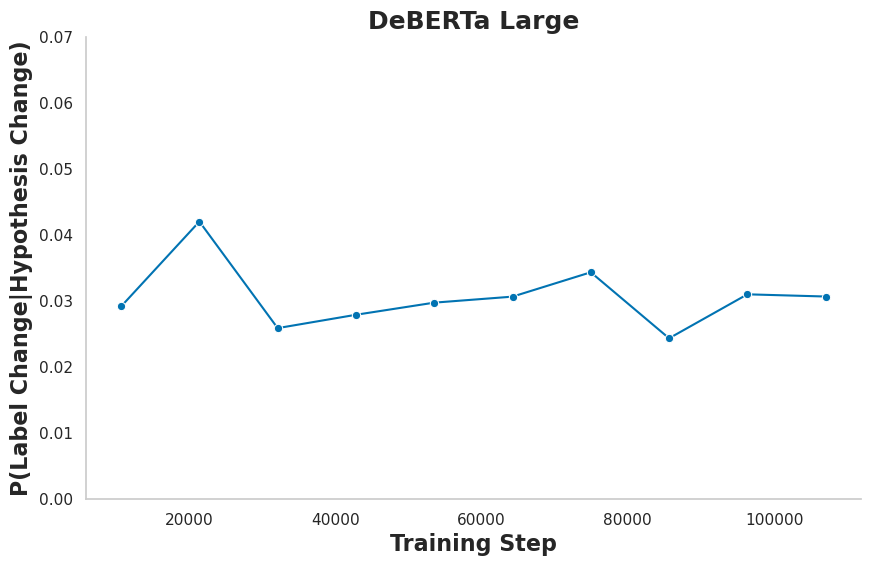

In [11]:
dl = stability_benchmark("training_large2", batch_size = 8)
dl['Model'] = 'DeBERTa Large'
plot_stability(dl, "DeBERTa Large")

# Plot All

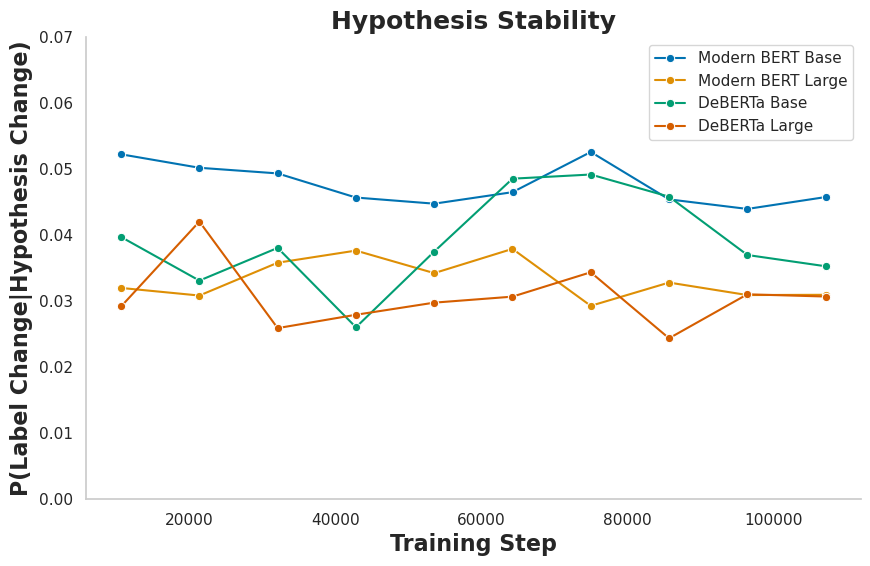

In [22]:
plot_stability([mbb, mbl, db, dl], title = 'Hypothesis Stability', save_path = 'Hypothesis Stability')